# Descriptive Statistics of Papers and Networks


In [15]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics

# inline
%matplotlib inline
import seaborn as sns

In [16]:
p = "../data/04-embeddings/df_with_specter2_embeddings.pkl"
df = pd.read_pickle(p)

# Descriptives of Papers per Year


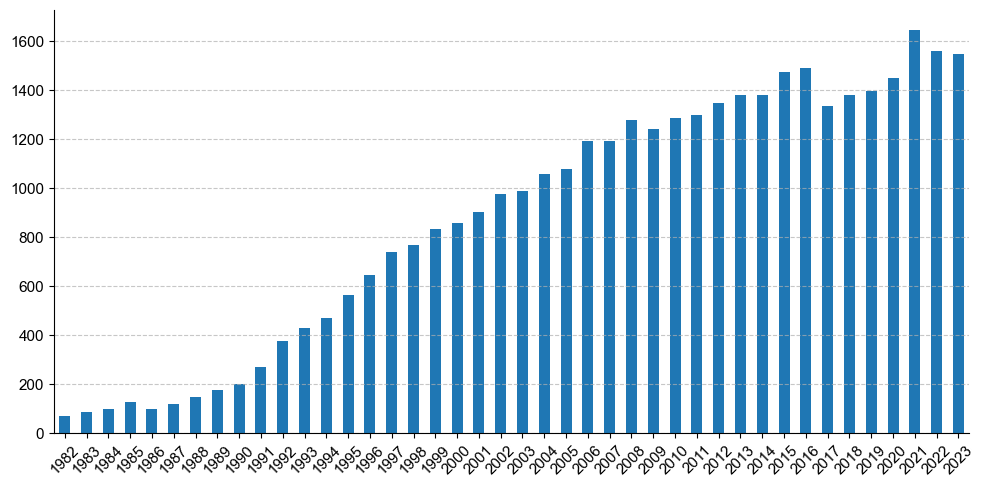

In [17]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})


# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
df["year"] = df["year"].astype(int)
df["year"].value_counts().sort_index().plot(kind="bar", figsize=(10, 5))
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/articles_per_year.png", dpi=300)
plt.show()

# Total number of referenced articles


In [18]:
df["nr_references"].sum()

1622970

# Number of references per paper per year


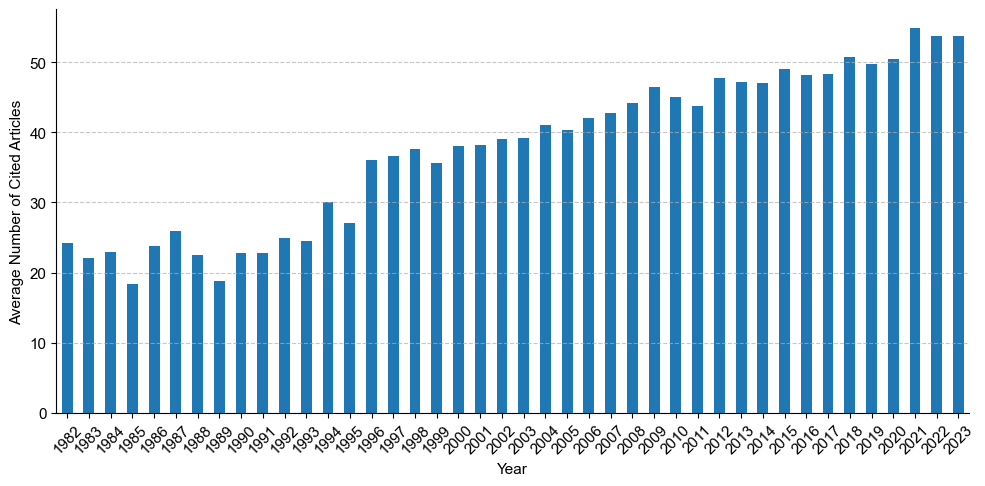

In [19]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})

# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_references_by_year = df.groupby("year")["nr_references"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
average_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Cited Articles"
)
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/total_average_references_by_year.png", dpi=300)
plt.show()

# Number of references per paper within Dataset


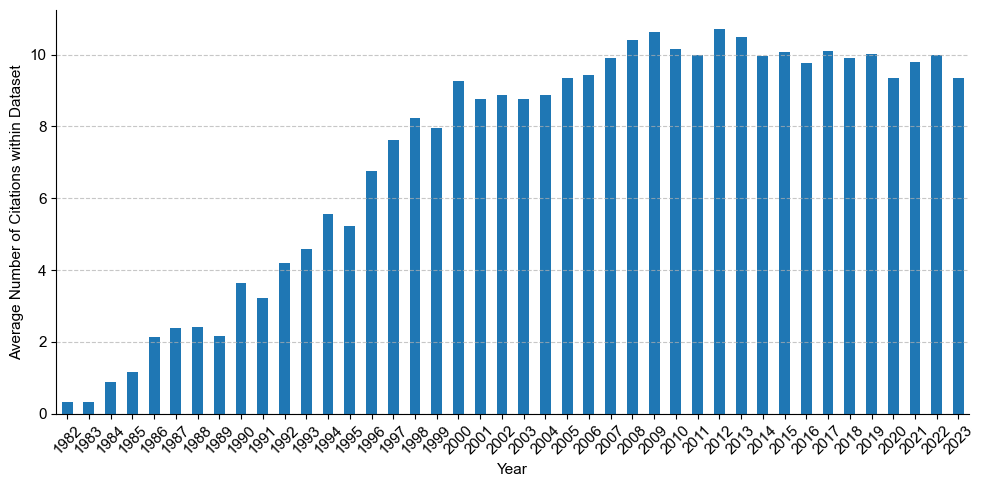

In [20]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})
# plot the average number of filtered references in a year
average_filtered_references_by_year = df.groupby("year")[
    "nr_filtered_references"
].mean()
plt.figure(figsize=(10, 5))
average_filtered_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Citations within Dataset"
)

# rotate xticks
plt.xticks(rotation=45)
# plt.title("Average Number of Filtered References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# remove top and right spines
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/filtered_average_references_by_year.png", dpi=300)
plt.show()

# Descriptives of the text


In [21]:
df["tokenized_titles_lens"] = df["title"].apply(lambda x: len(x.split()))

df["tokenized_abstracts_lens"] = df["abstract"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else None
)

# Get descriptive statistics
titles_stats = df["tokenized_titles_lens"].describe()
abstracts_stats = df["tokenized_abstracts_lens"].describe()

# Combine these statistics into a single DataFrame
summary_df = pd.DataFrame({"Titles": titles_stats, "Abstracts": abstracts_stats})

# If you want the DataFrame to be more readable, you might consider transposing it
summary_df_transposed = summary_df.T

# Count the number of NaNs for titles and abstracts
titles_nans = df["title"].isna().sum()
abstracts_nans = df["abstract"].isna().sum()

# skewness
titles_skewness = df["tokenized_titles_lens"].skew()
abstracts_skewness = df["tokenized_abstracts_lens"].skew()
median_titles = df["tokenized_titles_lens"].median()
median_abstracts = df["tokenized_abstracts_lens"].median()

# Append these counts to the summary DataFrame
# Since the summary DataFrame is transposed, we'll add them as new columns
summary_df_transposed["median"] = [median_titles, median_abstracts]
summary_df_transposed["skewness"] = [titles_skewness, abstracts_skewness]
summary_df_transposed["NaNs"] = [titles_nans, abstracts_nans]

# save to csv
summary_df_transposed.to_csv(
    "../output/tables/descriptives/summary_statistics_text_abstracts_titles.csv"
)
summary_df_transposed

,count,mean,std,min,25%,50%,75%,max,median,skewness,NaNs
Titles,36975.0,13.940933,5.239597,1.0,10.0,14.0,17.0,74.0,14.0,0.574908,0
Abstracts,36975.0,220.712400,88.862029,3.0,170.0,221.0,259.0,1826.0,221.0,2.685885,0


### Abstract lenghts per year


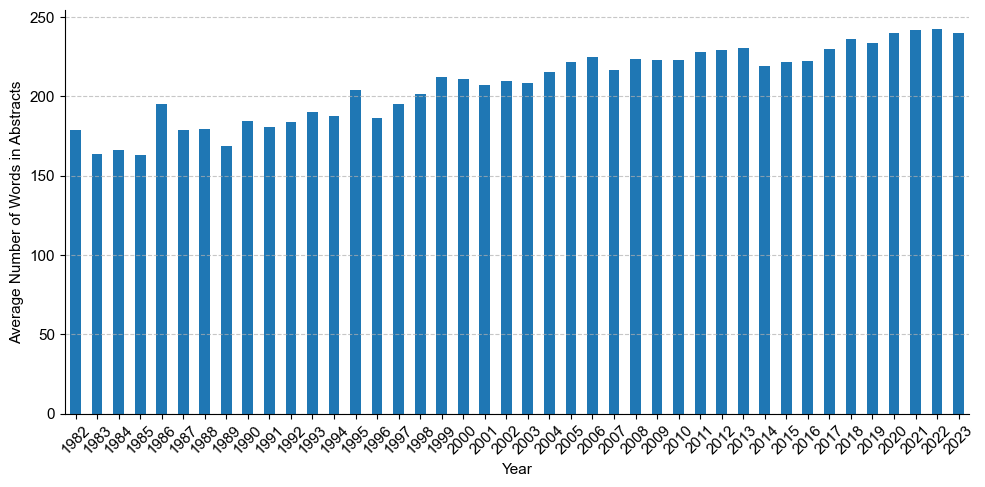

In [22]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})

# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_abs_lengths = df.groupby("year")["tokenized_abstracts_lens"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
average_abs_lengths.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Words in Abstracts"
)
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("../output/figures/average_abs_lengths.png", dpi=300)
plt.show()

# Descriptives of networks


In [23]:
import networkx as nx

In [24]:
# directed citation graph
p = "../data/05-graphs/citation-graph/directed_citation_graph.graphml"
G_dc = nx.read_graphml(p)

In [25]:
class NetworkDescriptives:
    def __init__(self, G):
        self.G = G
        self.directed = G.is_directed()
        print(f"Directed: {self.directed}")

    def basic_stats(self):
        """
        # (0-1 value;)
        # clustering coefficient is the average of the local clustering coefficient over all nodes in the graph
        # Local Clustering Coefficient: This measures how close a node's neighbors are to being a complete graph (clique). For a given node, it is the ratio of existing connections among its neighbors to all possible connections among them. (node a cites node b and c, but b and c do not cite each other)

        Calculate basic statistics of the network.

        Returns:
            A dictionary with the number of nodes, number of edges, network density,
            and average clustering coefficient.
        """
        stats = {
            "number_of_nodes": self.G.number_of_nodes(),
            "number_of_edges": self.G.number_of_edges(),
            "density": nx.density(self.G),
            "average_clustering_coefficient": nx.average_clustering(self.G),
        }

        return stats

    def in_out_degree(self):
        """
        Calculate and return summary statistics for in-degree and out-degree of the network.
        First establish the directedness of the graph, then calculate the in-degree and out-degree.

        Returns:
            A dictionary containing minimum, maximum, mean, and median for both in-degree and out-degree.
        """
        if self.directed:  # Remove parentheses from self.directed
            in_degrees = [deg for _, deg in self.G.in_degree()]
            out_degrees = [deg for _, deg in self.G.out_degree()]

            metrics = {
                "indegree": {
                    "min": min(in_degrees),
                    "max": max(in_degrees),
                    "mean": statistics.mean(in_degrees),
                    "median": statistics.median(in_degrees),
                    "range": f"{min(in_degrees)} to {max(in_degrees)}",
                },
                "outdegree": {
                    "min": min(out_degrees),
                    "max": max(out_degrees),
                    "mean": statistics.mean(out_degrees),
                    "median": statistics.median(out_degrees),
                    "range": f"{min(out_degrees)} to {max(out_degrees)}",
                },
            }
        else:
            degrees = [deg for _, deg in self.G.degree()]
            metrics = {
                "degree": {
                    "min": min(degrees),
                    "max": max(degrees),
                    "mean": statistics.mean(degrees),
                    "median": statistics.median(degrees),
                    "range": f"{min(degrees)} to {max(degrees)}",
                }
            }

        return metrics

    def connected_components(self):
        """
        Calculate and return various connected component metrics of the network.

        Returns:
            A dictionary with the number of strongly and weakly connected components,
            the size of the largest strongly connected component (GCC),
            and the size of the largest weakly connected component.
        """
        # Strongly connected components
        sccs = list(nx.strongly_connected_components(self.G))
        largest_scc_size = len(max(sccs, key=len))

        # Weakly connected components
        wccs = list(nx.weakly_connected_components(self.G))
        largest_wcc_size = len(max(wccs, key=len))

        # Compile metrics into a dictionary for clarity and extensibility
        metrics = {
            "num_strongly_connected_components": len(sccs),
            "largest_strongly_connected_component_size": largest_scc_size,
            "num_weakly_connected_components": len(wccs),
            "largest_weakly_connected_component_size": largest_wcc_size,
        }

        return metrics

    def main(self):
        """
        Calculate and return all network descriptives.

        Returns:
            A dictionary containing basic statistics, in-degree and out-degree summary statistics,
            and connected component metrics.
        """
        descriptives = {
            "basic_statistics": self.basic_stats(),
            "in_out_degree": self.in_out_degree(),
        }
        if self.directed:  # Remove parentheses from self.directed()
            descriptives["connected_components"] = self.connected_components()

        return descriptives

# Directed Network Descriptives


In [26]:
import json

descriptives_dc = NetworkDescriptives(G_dc).main()
# save to json
with open(
    "../output/tables/descriptives/network_direct_citations_descriptives.json", "w"
) as f:
    json.dump(descriptives_dc, f, indent=4)
descriptives_dc

Directed: True


{'basic_statistics': {'number_of_nodes': 36975,
  'number_of_edges': 336391,
  'density': 0.00024605927970948135,
  'average_clustering_coefficient': 0.08078528315193657},
 'in_out_degree': {'indegree': {'min': 0,
   'max': 683,
   'mean': 9.097795807978363,
   'median': 3,
   'range': '0 to 683'},
  'outdegree': {'min': 0,
   'max': 274,
   'mean': 9.097795807978363,
   'median': 6,
   'range': '0 to 274'}},
 'connected_components': {'num_strongly_connected_components': 36853,
  'largest_strongly_connected_component_size': 16,
  'num_weakly_connected_components': 2108,
  'largest_weakly_connected_component_size': 34795}}

# Hybrid Network


In [27]:
# directed citation graph
p = "../data/05-graphs/weighted-knn-citation-graph/weighted_alpha0.3_k20_knn_citation.graphml"
G_hybrid = nx.read_graphml(p)

In [28]:
descriptives_hybrid = NetworkDescriptives(G_hybrid).main()

# save to json
with open("../output/tables/descriptives/network_hybrid_descriptives.json", "w") as f:
    json.dump(descriptives_dc, f, indent=4)

descriptives_hybrid

Directed: False


{'basic_statistics': {'number_of_nodes': 36975,
  'number_of_edges': 821683,
  'density': 0.0012020697767153449,
  'average_clustering_coefficient': 0.2282503421825546},
 'in_out_degree': {'degree': {'min': 19,
   'max': 695,
   'mean': 44.44532792427316,
   'median': 35,
   'range': '19 to 695'}}}